Analysis of friction in i-PI
----------------------------

Run the following simulations with i-PI for checking the NVE ensemble

| Driver \ Dyn. | NVE | NVE-f (BAFAB) | NVE-f (FBABF)
| --- | --- | --- | --- |
| Doublewell 1D | DW-NVE | DW-NVE-BAFAB | DW-NVE-FBABF |
| Doublewell 1D with friction | DWFriction-NVE | DWFriction-NVE-BAFAB | DWFriction-NVE-FBABF |



In [ ]:
%%bash
# Run all simulations if necessary
set -e
for sim in DW{,Friction}-NVE{,-bafab,-fbabf}
do
    if [ ! -f "$sim/simulation.out" ]; then
        pushd $sim/
        bash clean.sh
        bash run.sh
        popd
    fi
done

For this analysis we need `polars` and `matplotlib`.
Install them if necessary with `mamba install -c conda-forge polars matplotlib-base`.

In [3]:
import polars as pl
import matplotlib.pyplot as plt

Read i-PI simulation outputs as dataframe, we have two types of files from our example simulations, `simulation.out` with key properties and trajectories in `simulation.*_c.xyz` for the vectorial quantities of the centroids, like positions or forces.

In [6]:
def read_simulation_out(filename: str) -> pl.DataFrame:
    """Read simulation output from an i-PI simulation.out file into a Polars DataFrame."""
    with open(filename, "r") as fd:
        lines = fd.readlines()
        data = {
            line.split("-->")[-1].split(":")[0].strip(): [] for line in lines if line.startswith("#")
        }
        for line in lines[len(data):]:
            values = line.strip().split()
            for i, key in enumerate(data.keys()):
                data[key].append(float(values[i]))

    df = pl.DataFrame(data)
    return df

def read_simulation_pos_xyz(filenames: dict[str, str]) -> pl.DataFrame:
    """Read multiple simulation.pos.xyz outputs from i-PI simulations into a single Polars DataFrame."""
    all_data = {}
    for prefix, filename in filenames.items():
        data = _read_simulation_pos_xyz(filename, prefix=prefix + "_")
        all_data.update(data)
    df = pl.DataFrame(all_data)
    return df

def _read_simulation_pos_xyz(filename: str, prefix: str = "") -> dict[str, list]:
    """Read simulation.pos.xyz output from an i-PI simulation.out file."""
    data = {
        f"{prefix}step": [],
        f"{prefix}comment": [],
    }
    with open(filename, "r") as fd:
        lines = fd.readlines()
        n_atoms, i_atom, i_frame = 0, 0, 0
        expect_comment = False
        for line in lines:
            line = line.strip()
            if n_atoms == 0 or i_atom == n_atoms:
                n_atoms = int(line)
                i_atom = 0
                i_frame += 1
                data[f"{prefix}step"].append(i_frame)
                expect_comment = True
                continue
            if expect_comment:
                data[f"{prefix}comment"].append(line)
                expect_comment = False
                continue
            i_atom += 1
            element, x, y, z = line.split()
            for key, value in zip(
                (f"{prefix}element{i_atom}", f"{prefix}x{i_atom}", f"{prefix}y{i_atom}", f"{prefix}z{i_atom}"),
                (element, float(x), float(y), float(z)),
            ):
                if key not in data:
                    data[key] = []
                data[key].append(value)
    return data

In [7]:
SIMULATIONS = [
    "DW-NVE",
    "DW-NVE-bafab",
    "DW-NVE-fbabf",
    "DWFriction-NVE",
    "DWFriction-NVE-bafab",
    "DWFriction-NVE-fbabf",
]

PROPERTIES = ["pos", "vel", "frc", "mom"]

data = {
    simulation: read_simulation_out(f"{simulation}/simulation.out")
    for simulation in SIMULATIONS
}

traj = {
    simulation: read_simulation_pos_xyz(
        {
            prop: f"{simulation}/simulation.{prop}_c.xyz"
            for prop in PROPERTIES
        }
    )
    for simulation in SIMULATIONS
}

In [8]:
data["DW-NVE"].head()

shape: (5, 5)
┌──────┬───────────┬─────────────────────┬─────────────────────────┬────────────┐
│ step ┆ conserved ┆ temperature{kelvin} ┆ potential{electronvolt} ┆ kinetic_md │
│ ---  ┆ ---       ┆ ---                 ┆ ---                     ┆ ---        │
│ f64  ┆ f64       ┆ f64                 ┆ f64                     ┆ f64        │
╞══════╪═══════════╪═════════════════════╪═════════════════════════╪════════════╡
│ 0.0  ┆ 0.000192  ┆ 1.263712            ┆ 0.0                     ┆ 0.000192   │
│ 1.0  ┆ 0.000192  ┆ 1.141477            ┆ -0.000011               ┆ 0.000174   │
│ 2.0  ┆ 0.000192  ┆ 0.836683            ┆ -0.000041               ┆ 0.000127   │
│ 3.0  ┆ 0.000192  ┆ 0.500454            ┆ -0.000077               ┆ 0.000076   │
│ 4.0  ┆ 0.000192  ┆ 0.289646            ┆ -0.00011                ┆ 0.000044   │
└──────┴───────────┴─────────────────────┴─────────────────────────┴────────────┘

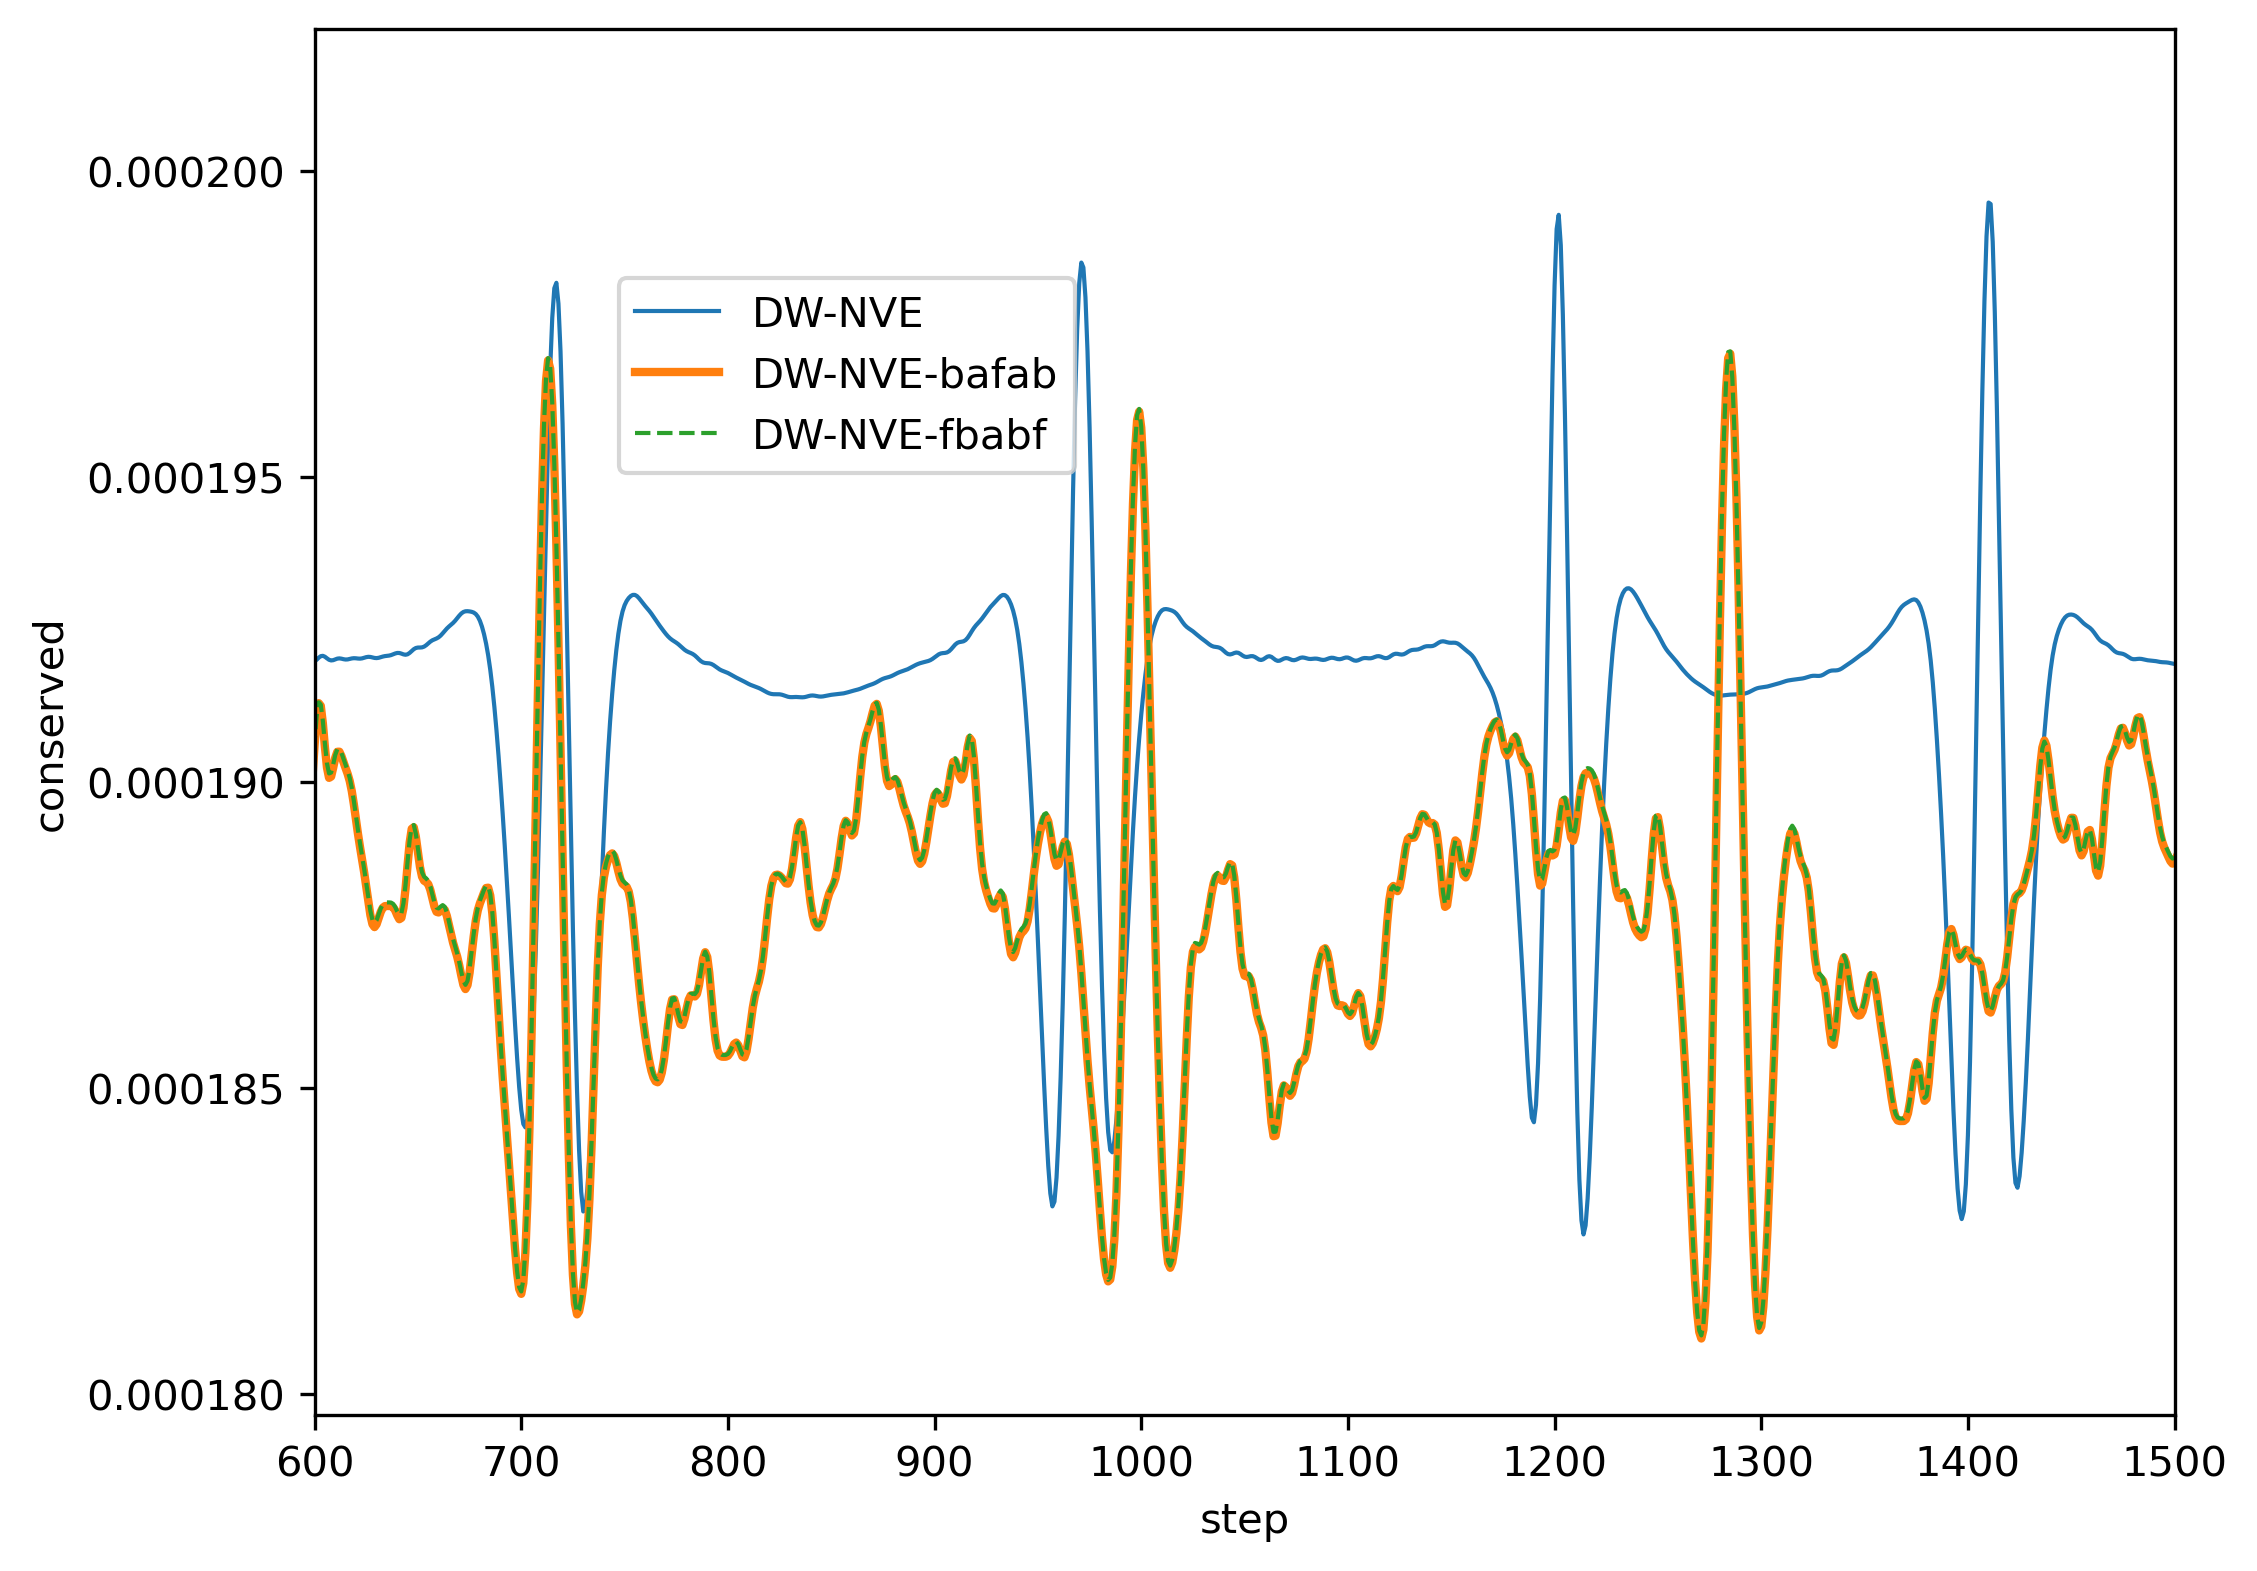

In [46]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
#quantity = "potential{electronvolt}"
quantity = "conserved"
#quantity = "temperature{kelvin}"
#quantity = "kinetic_md"
for simulation, df in data.items():
    if simulation.startswith("DWFric") or "NVT" in simulation:
        continue
    ax.plot(
        df["step"],
        df[quantity],
        label=simulation,
        linestyle="--" if simulation.startswith("DW-NVE-fb") else "-",
        linewidth=2 if simulation.startswith("DW-NVE-ba") else 1,
    )
    #plot x axis till 1000 steps
    ax.set_xlim(600, 1500)
    ax.set_xlabel("step")
    ax.set_ylabel(quantity)
    ax.legend( bbox_to_anchor=(0.42, 0.75), loc='right')

plt.show()  
# save in figures directory 
#fig.savefig(f"figures/NVE-{quantity}.png")

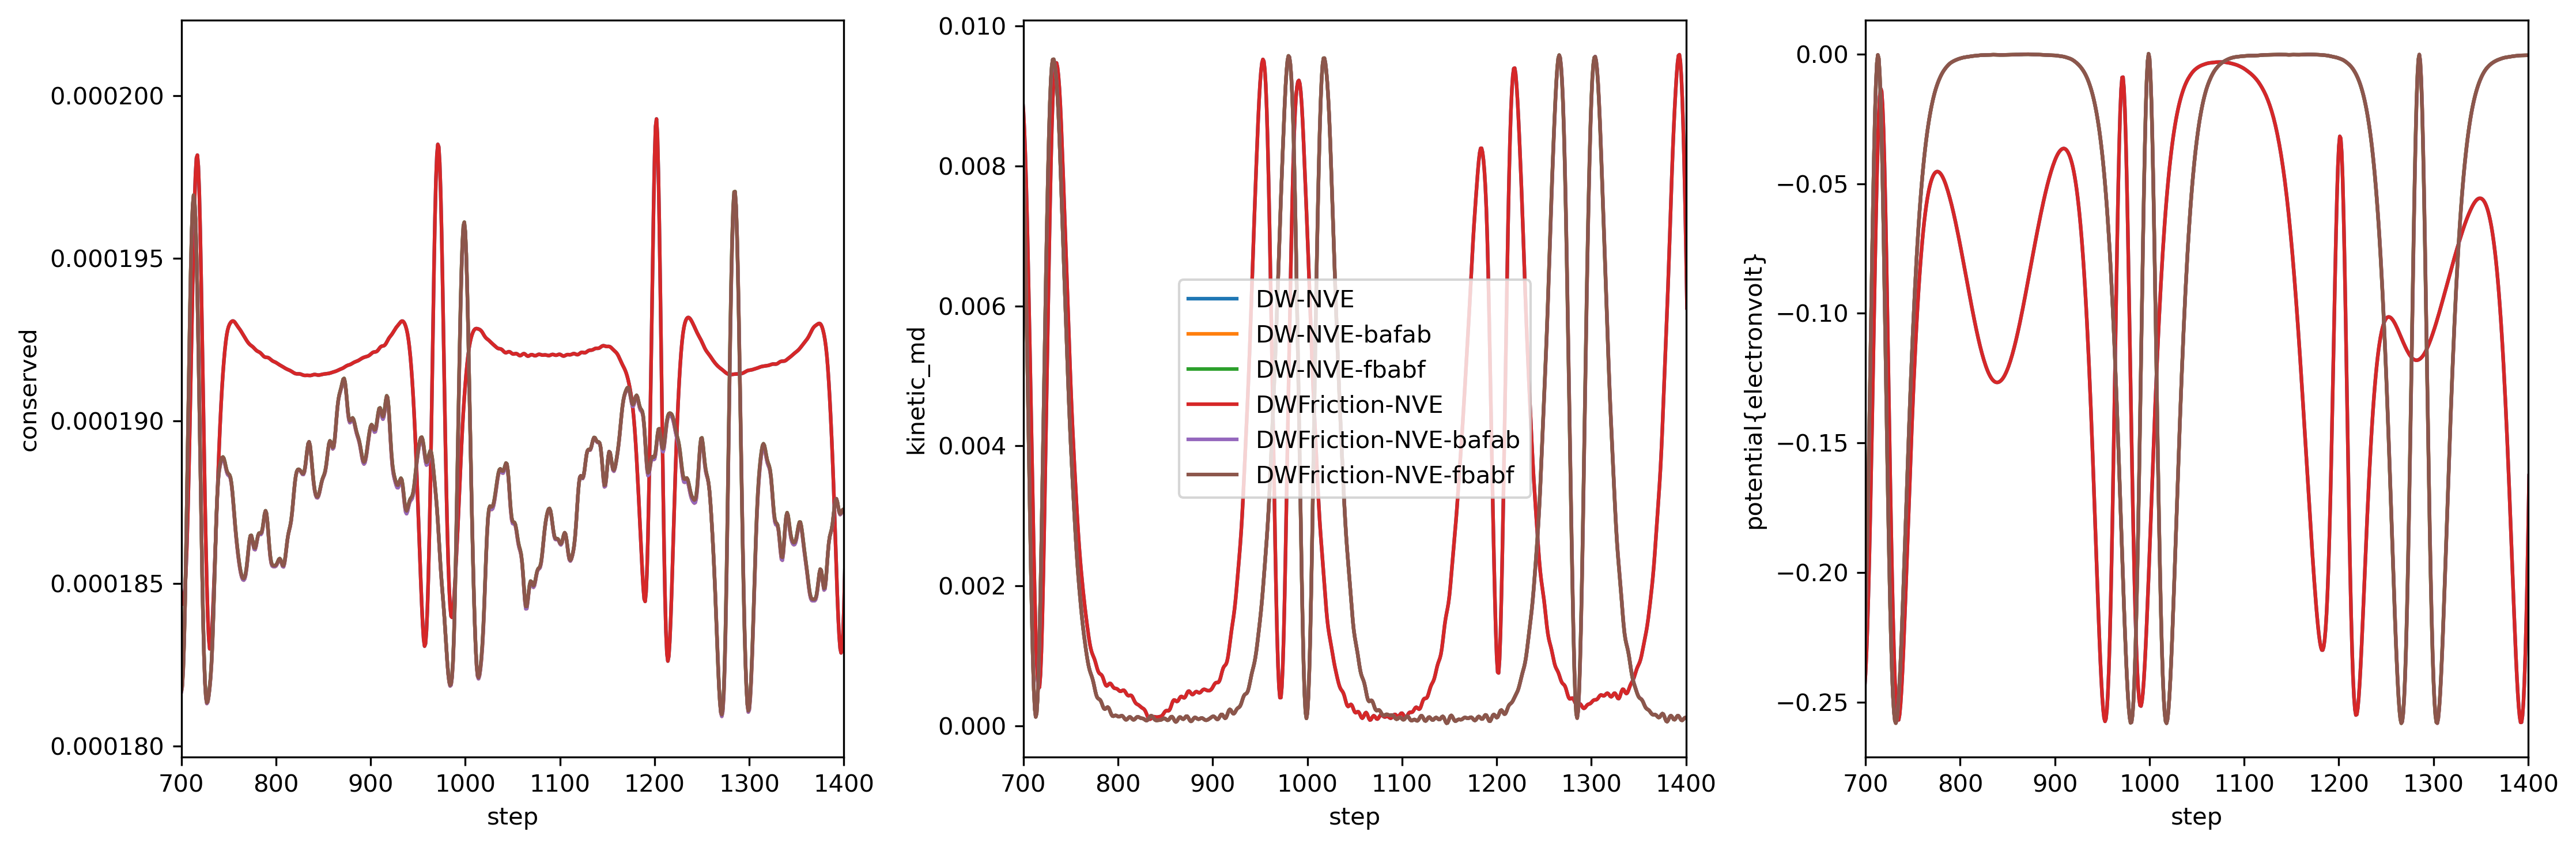

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, tight_layout=True)
for ax, quantity in zip(axes, ["conserved", "kinetic_md", "potential{electronvolt}"]):
    for simulation, df in data.items():
        ax.plot(
            df["step"],
            df[quantity],
            label=simulation,
        )
    ax.set_xlim(700, 1400)
    ax.set_xlabel("step")
    ax.set_ylabel(quantity)
    if quantity == "kinetic_md":
        ax.legend()
plt.show()

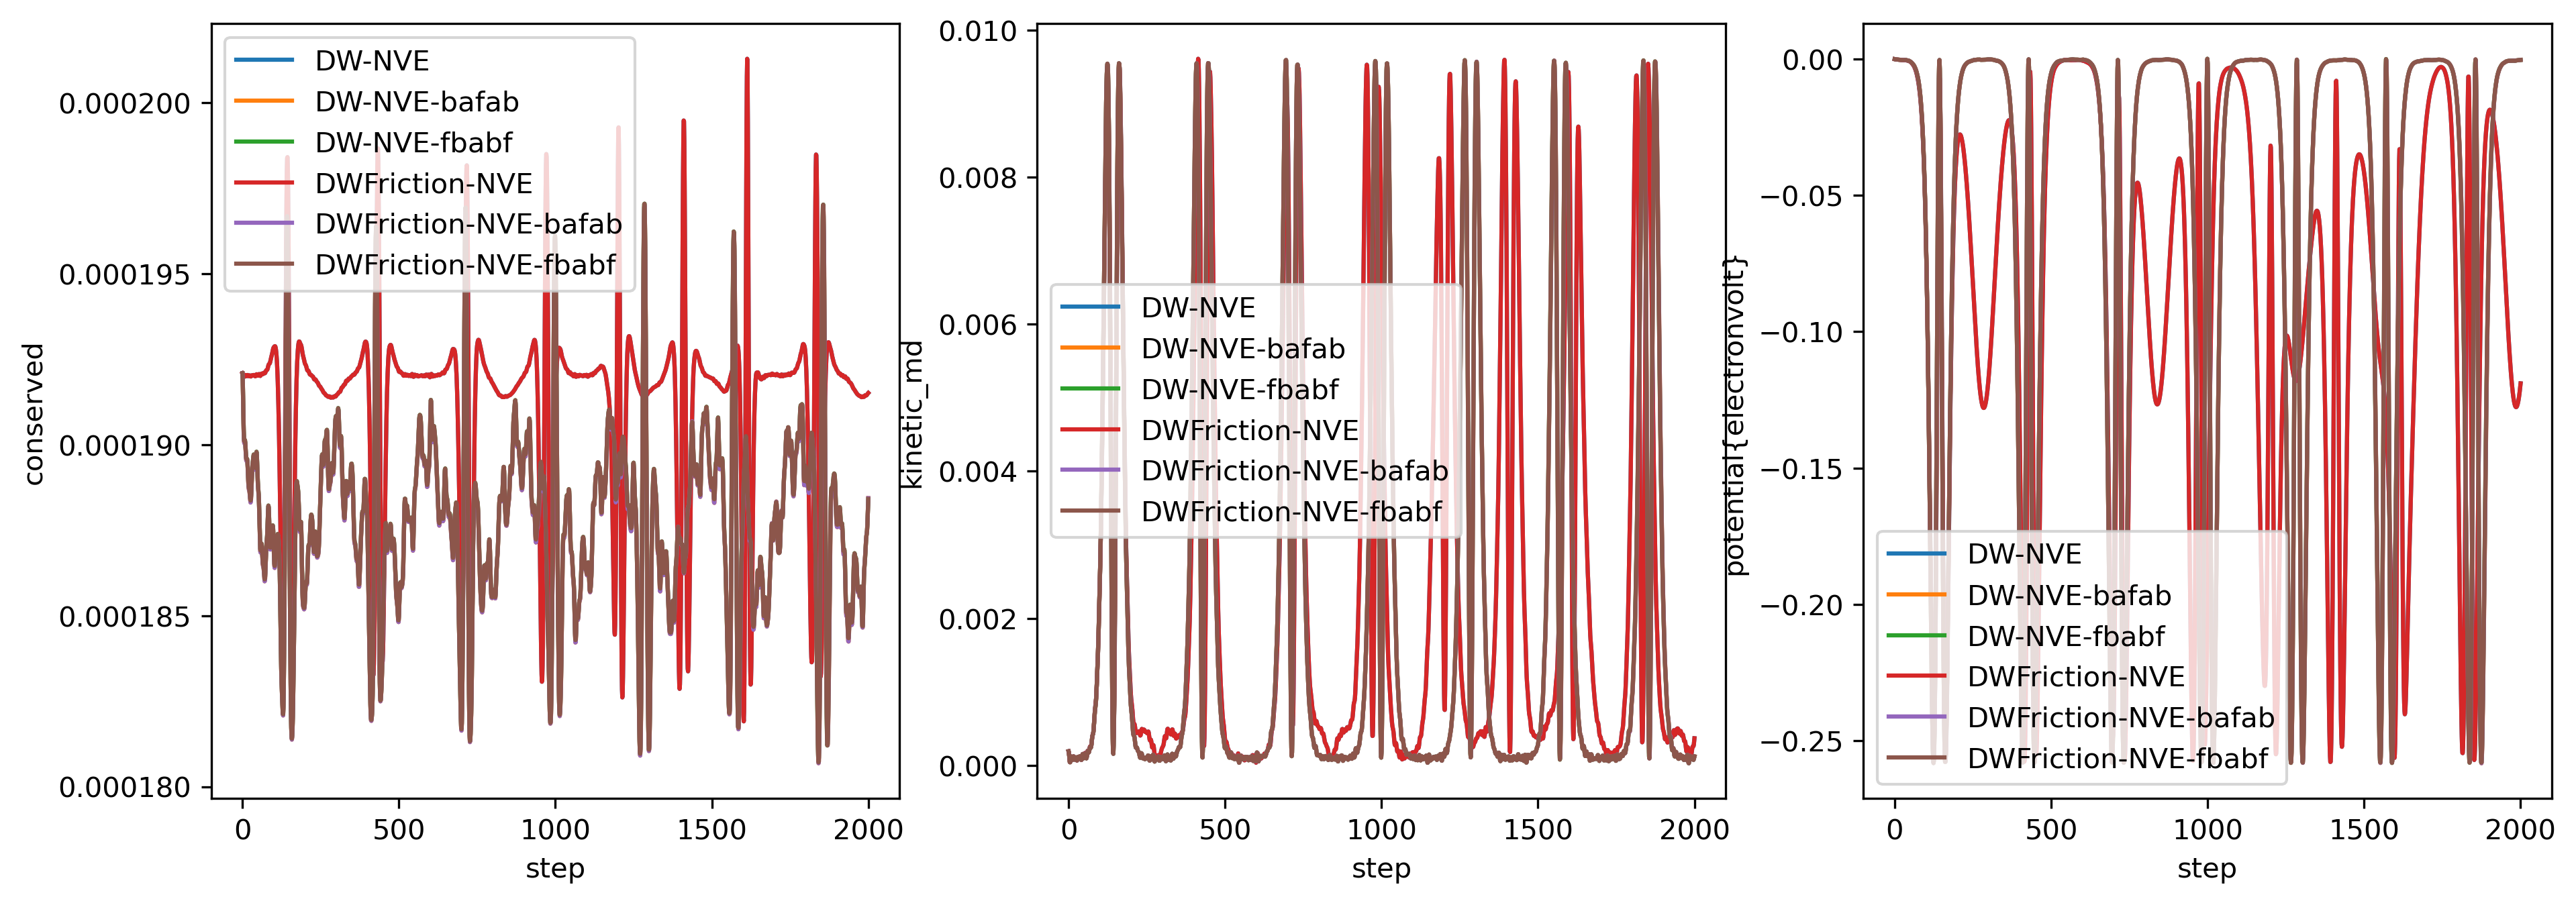

In [11]:
import matplotlib.pyplot as plt
# Make three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
for ax, quantity in zip(axes, ["conserved", "kinetic_md", "potential{electronvolt}"]):
    for simulation, df in data.items():
        if "NVT" in simulation:
            continue
        ax.plot(
            df["step"],
            df[quantity],
            label=simulation,
        )
    ax.set_xlabel("step")
    ax.set_ylabel(quantity)
    ax.legend()
plt.show()  


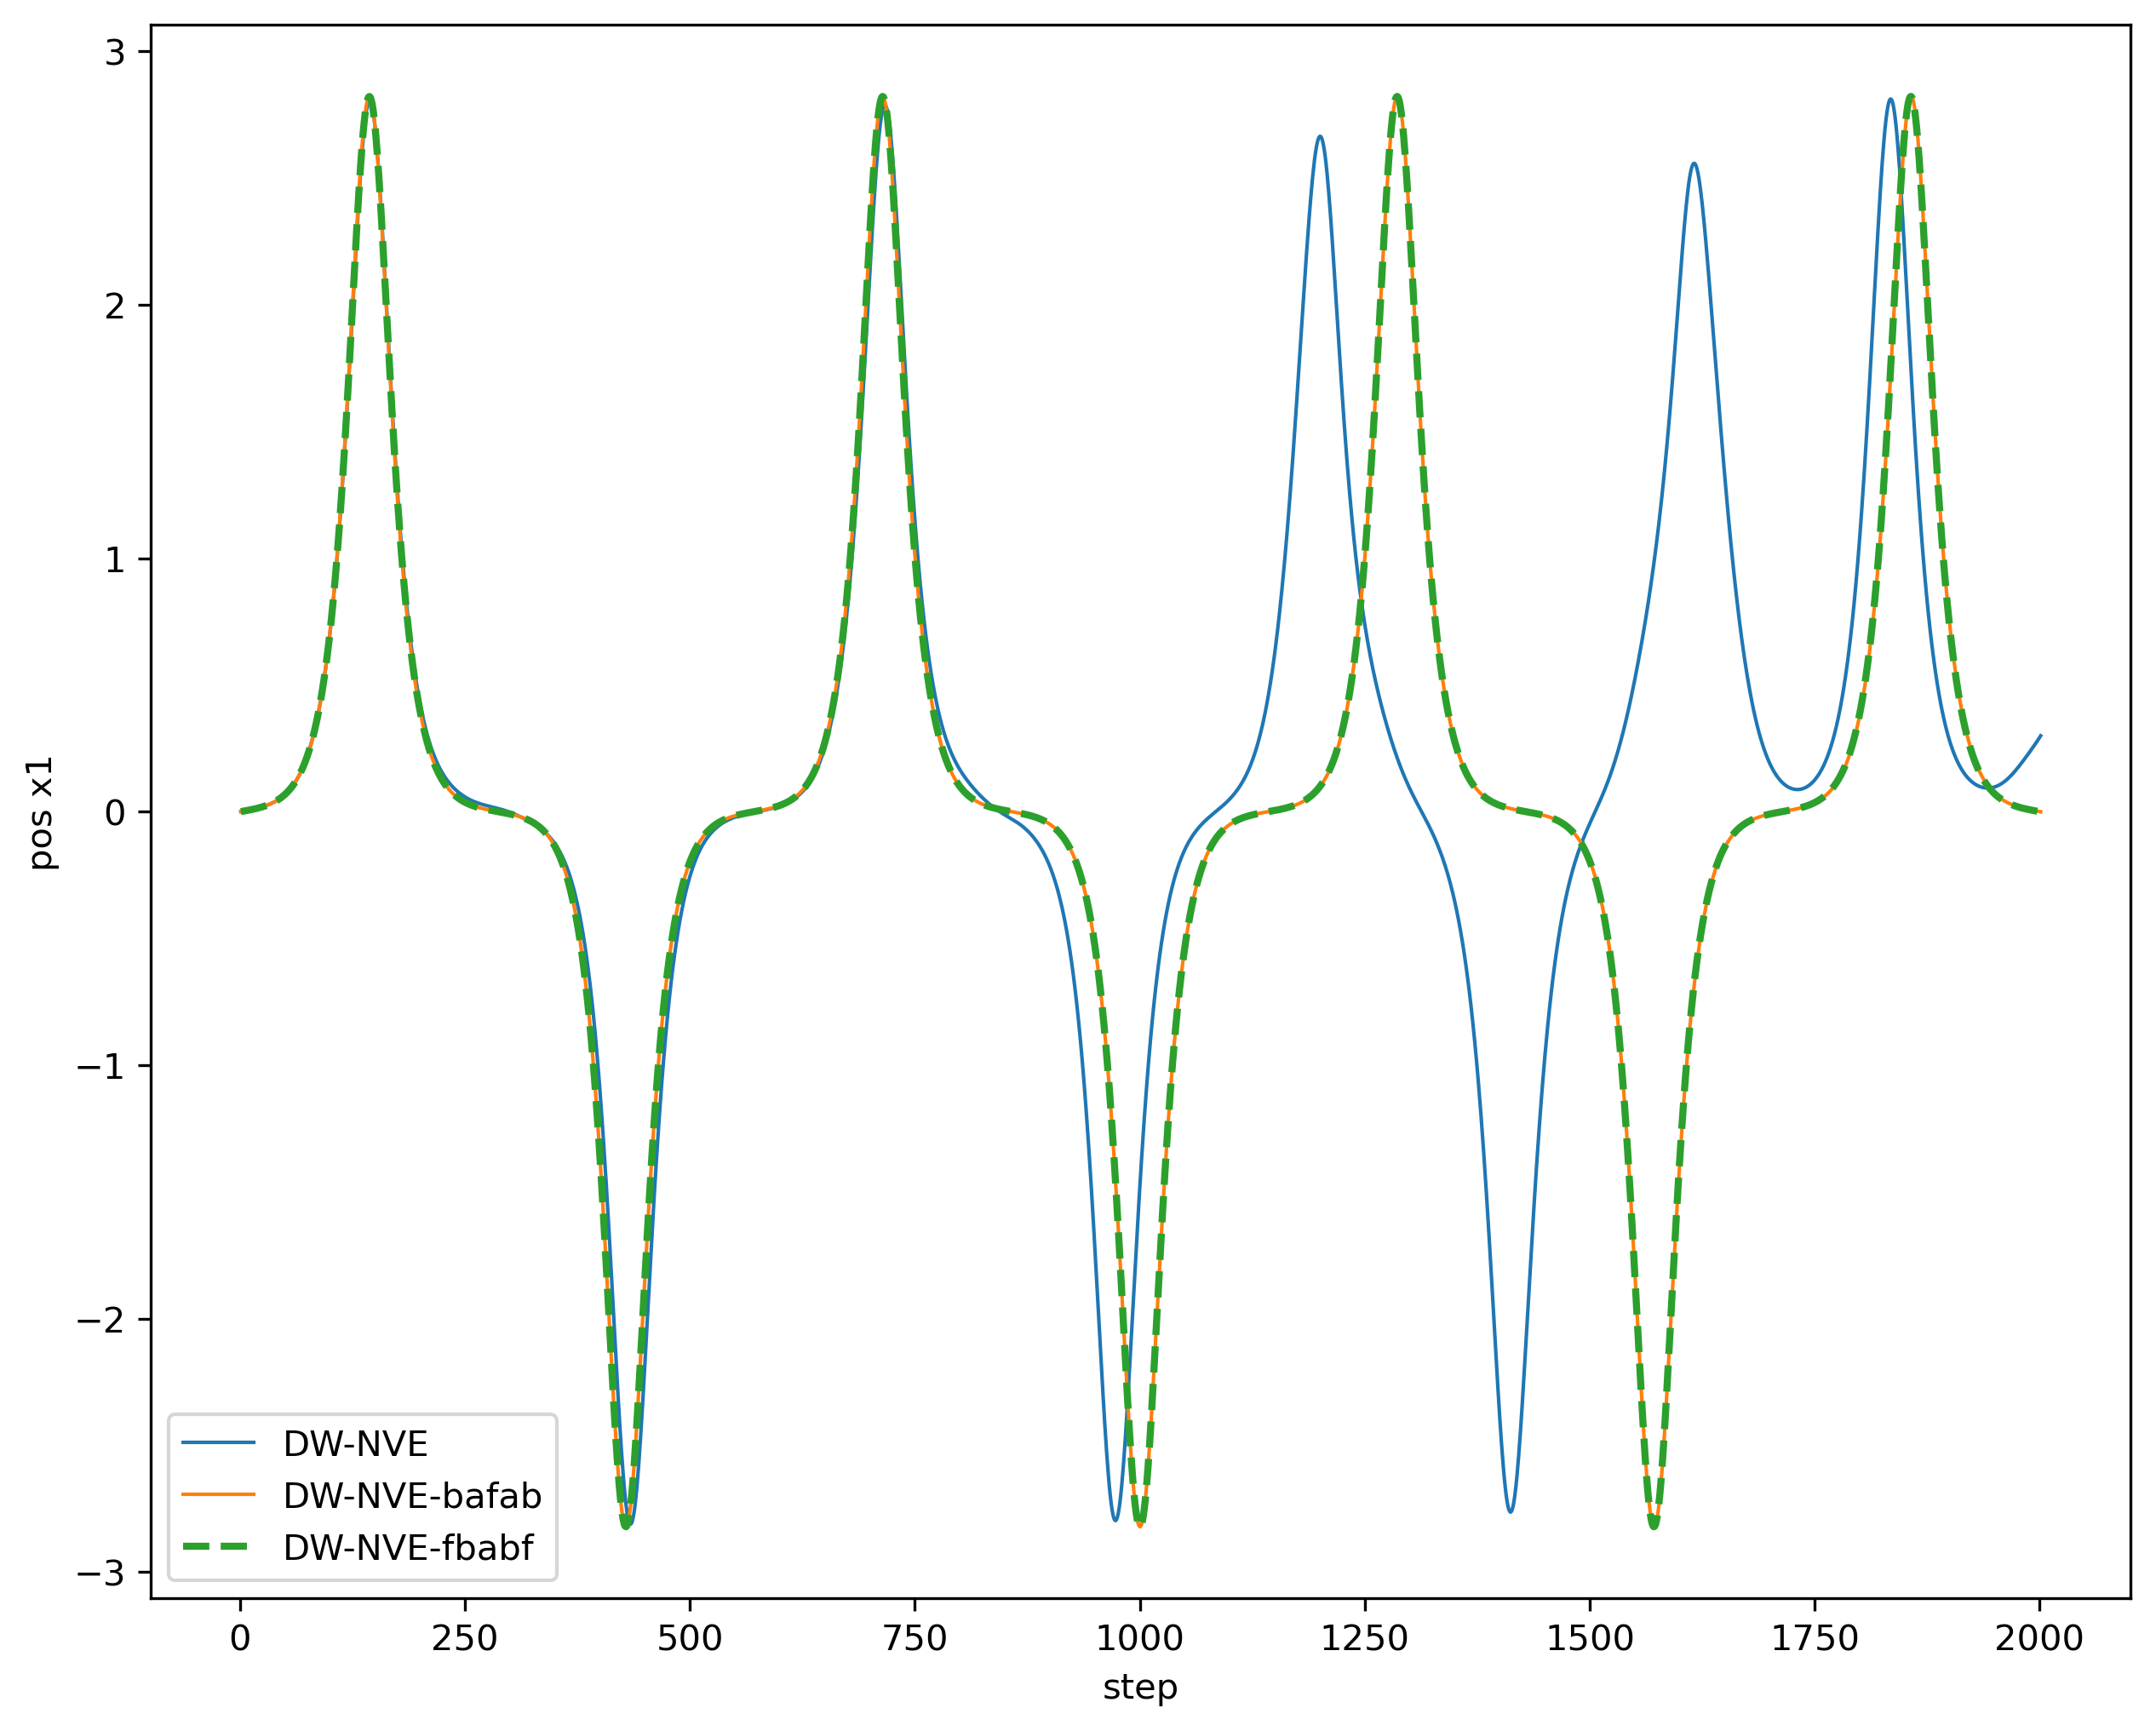

In [42]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

prop = "pos"
quantity = f"x1"
for simulation, df in traj.items():
        if simulation.startswith("DWFric") or "NVT" in simulation:
            continue
        ax.plot(
            df[f"{prop}_step"],
            df[f"{prop}_{quantity}"],
            label=simulation,
            linestyle="--" if simulation.startswith("DW-NVE-f") else "-",
            linewidth=2 if simulation.startswith("DW-NVE-f") else 1,
        )
ax.set_xlabel("step")
ax.set_ylabel(f"{prop} {quantity}")
ax.legend()
plt.show()
# save in figures directory
fig.savefig(f"figures/NVE-{prop}-{quantity}.png")

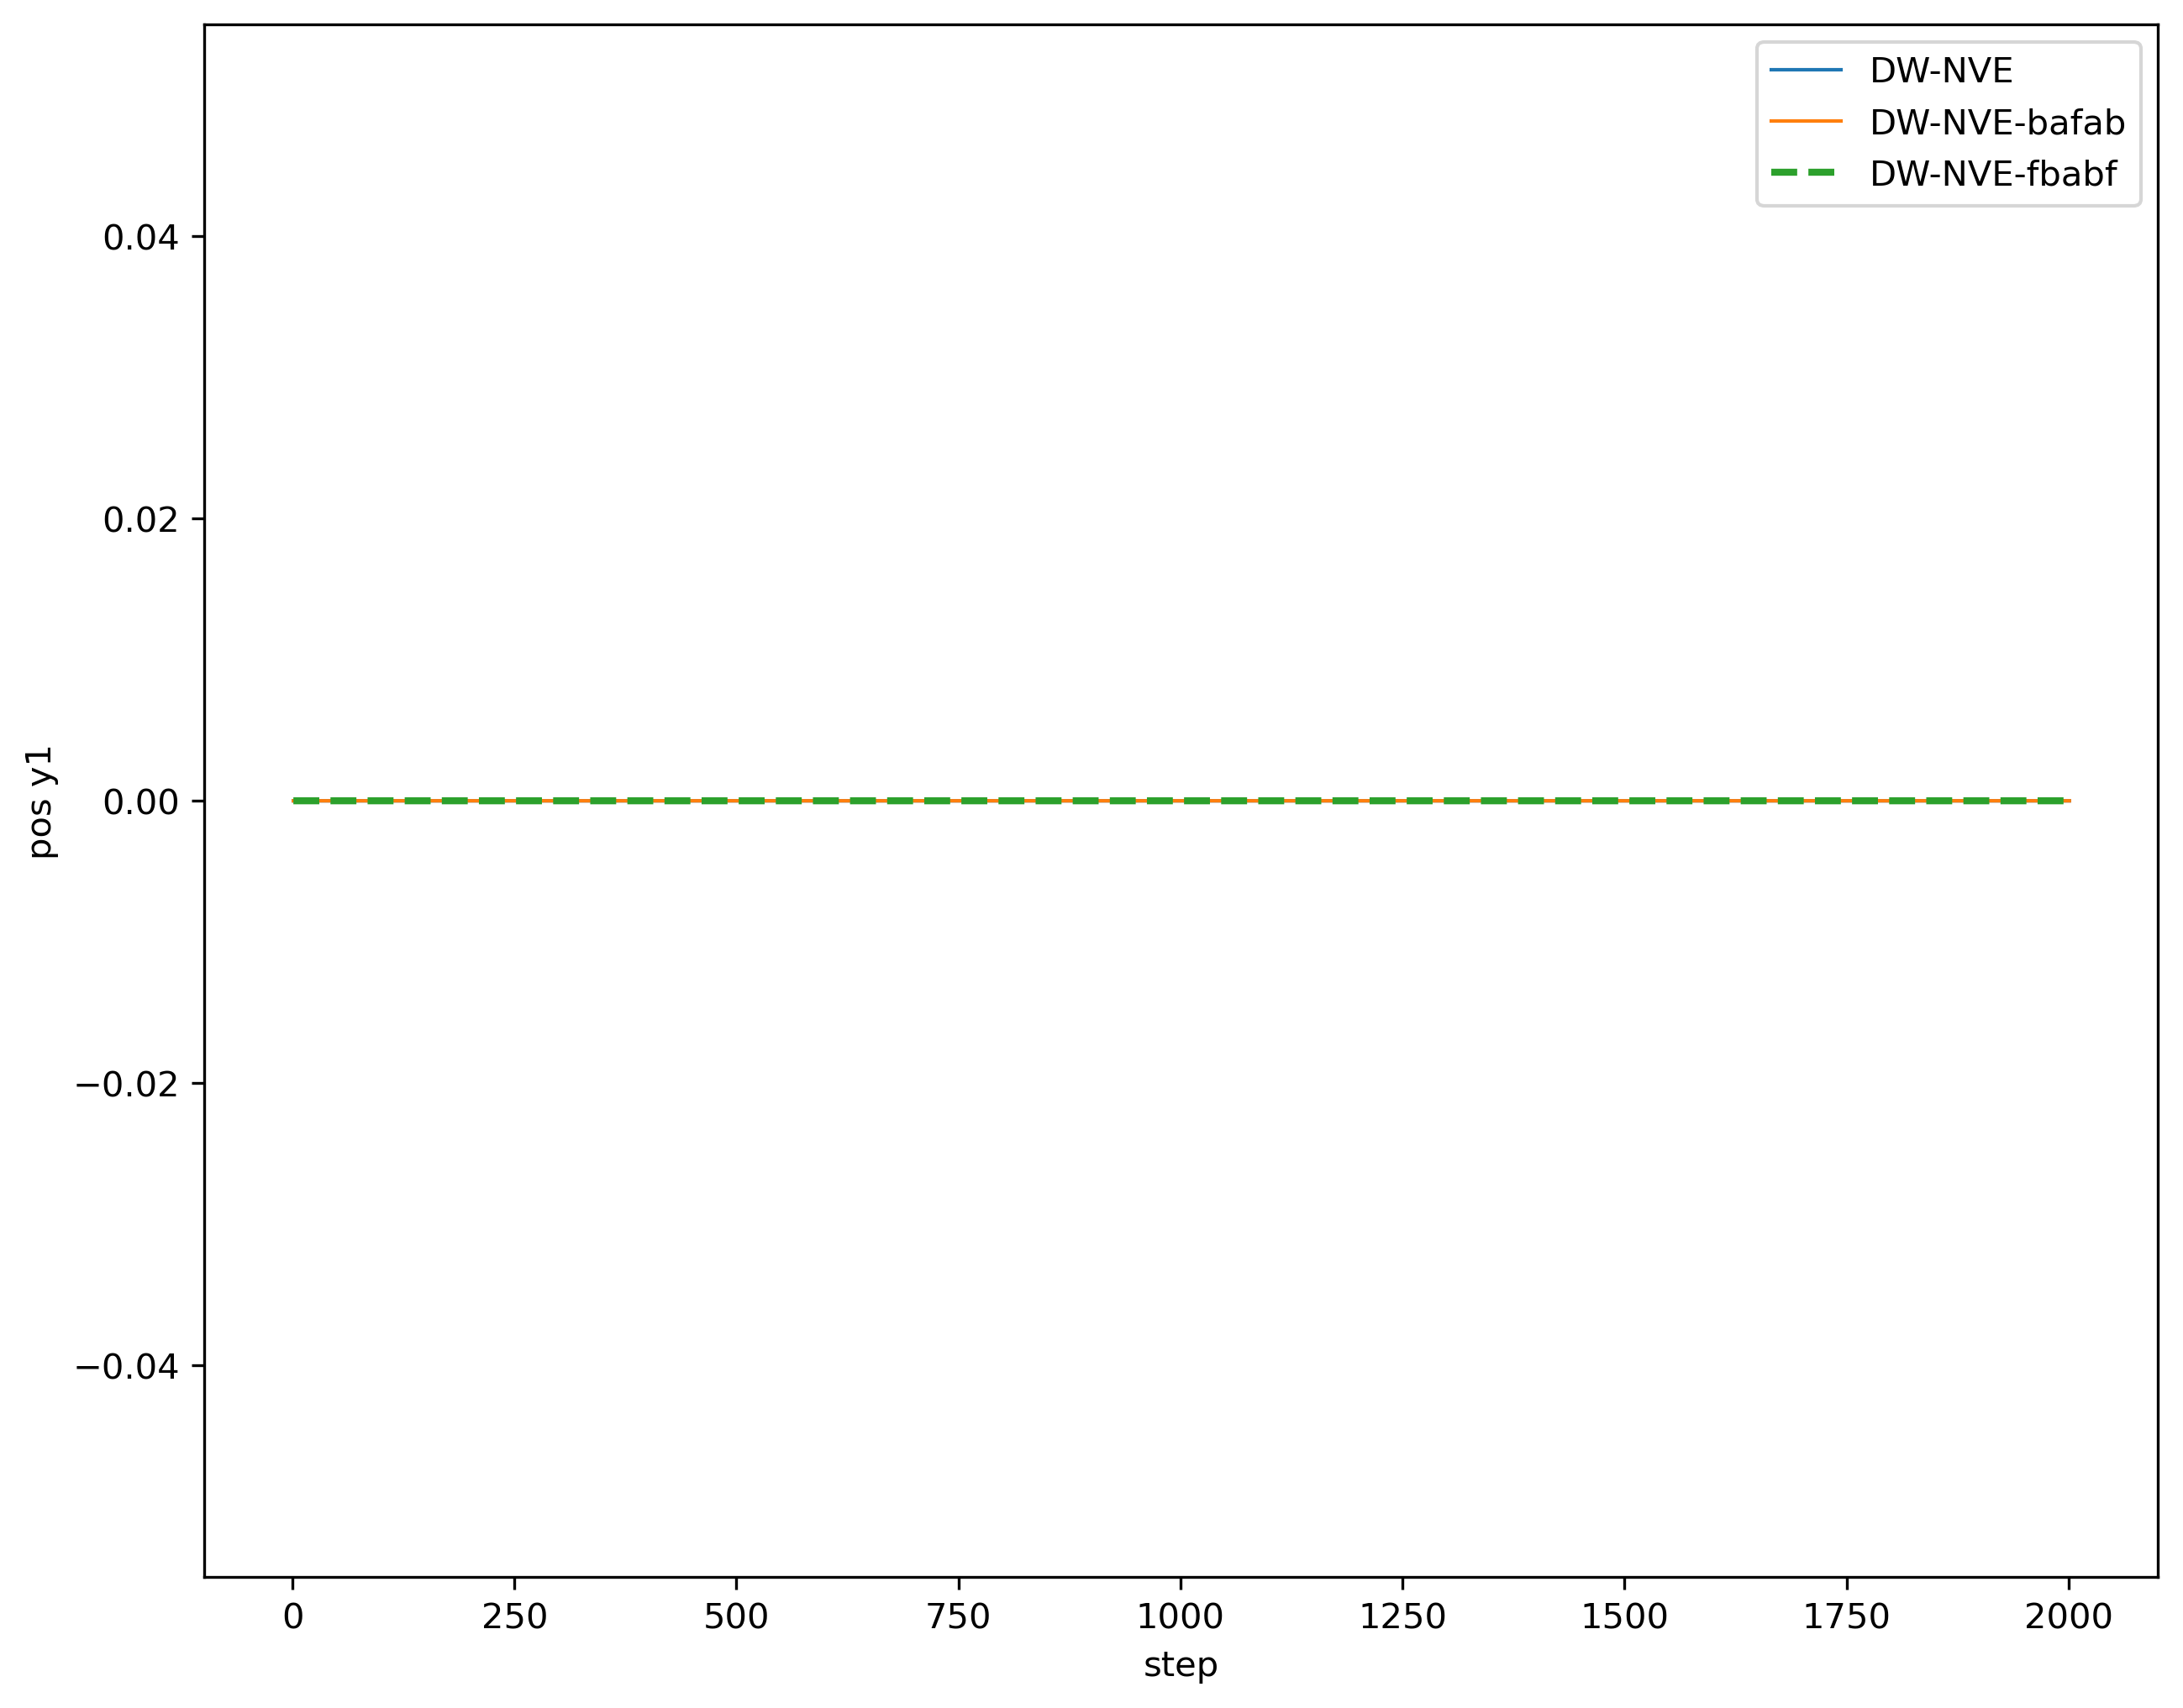

In [40]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

prop = "pos"
quantity = f"y1"
for simulation, df in traj.items():
        if simulation.startswith("DWFric") or "NVT" in simulation:
            continue
        ax.plot(
            df[f"{prop}_step"],
            df[f"{prop}_{quantity}"],
            label=simulation,
            linestyle="--" if simulation.startswith("DW-NVE-f") else "-",
            linewidth=2 if simulation.startswith("DW-NVE-f") else 1,
        )
ax.set_xlabel("step")
ax.set_ylabel(f"{prop} {quantity}")
ax.legend()
plt.show()
# save in figures directory
fig.savefig(f"figures/NVE-{prop}-{quantity}.png")

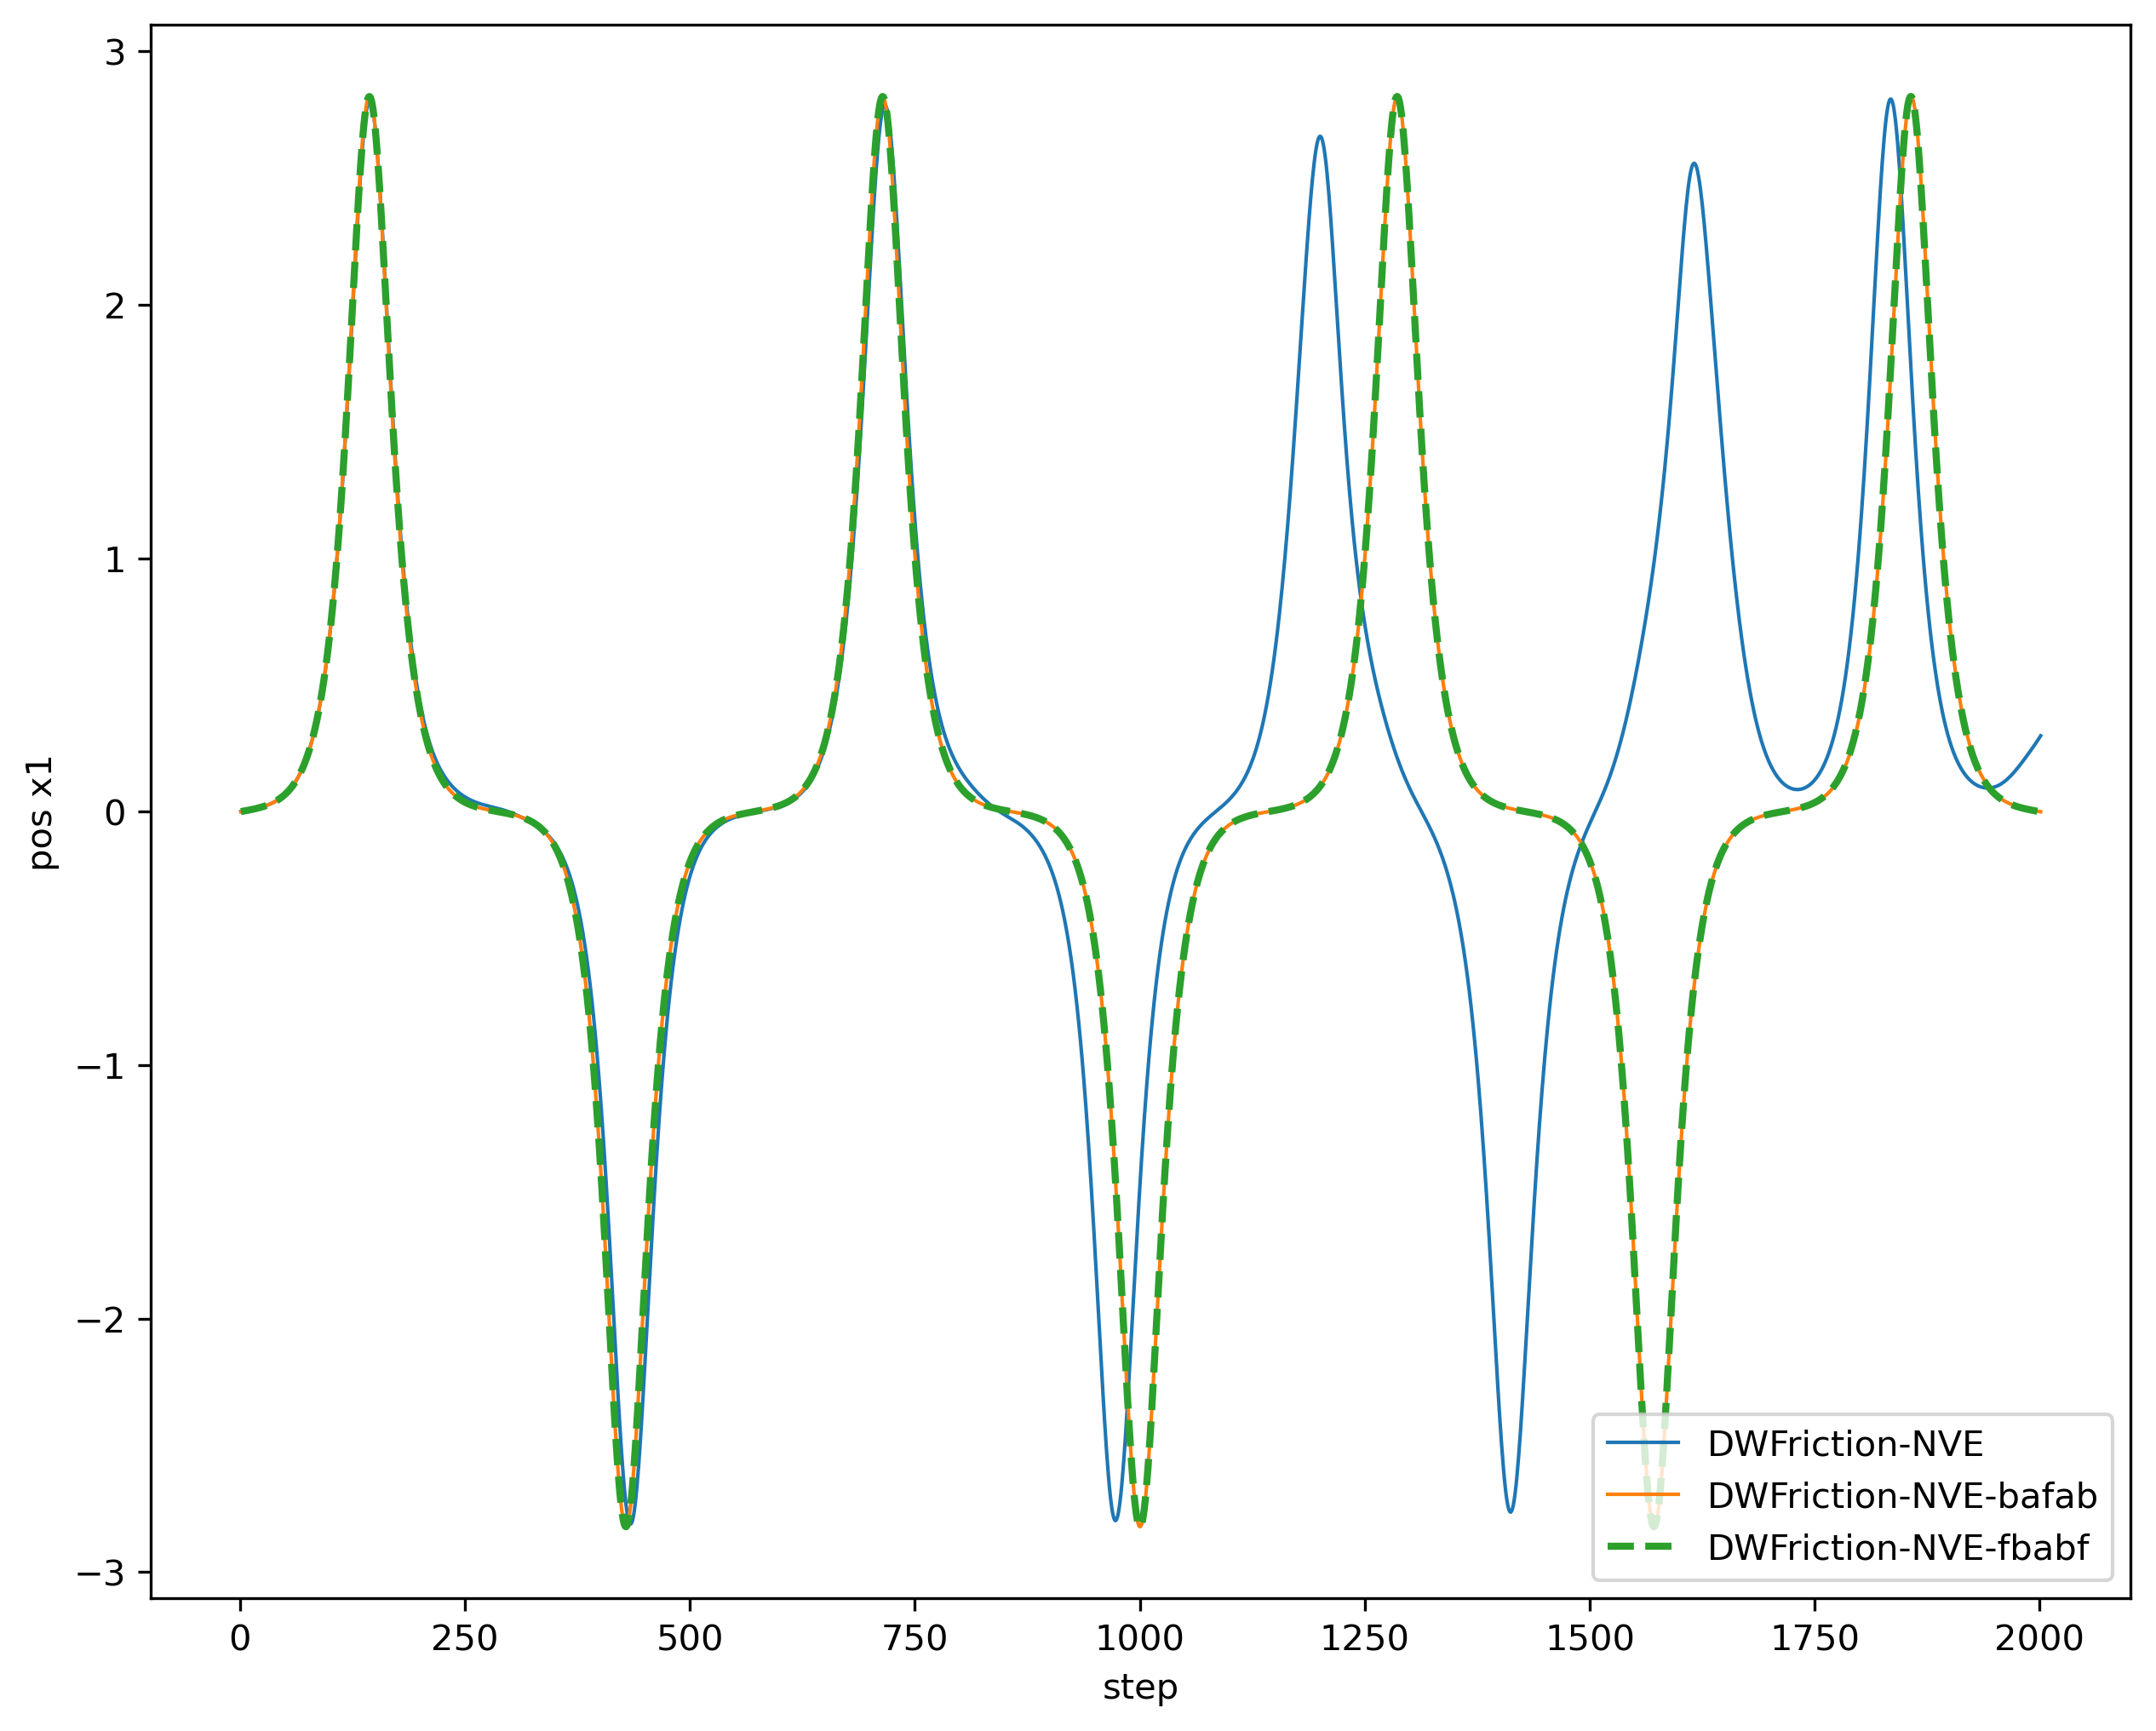

In [43]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

prop = "pos"
quantity = f"x1"
for simulation, df in traj.items():
        if simulation.startswith("DW-NVE") or "NVT" in simulation:
            continue
        ax.plot(
            df[f"{prop}_step"],
            df[f"{prop}_{quantity}"],
            label=simulation,
            linestyle="--" if simulation.startswith("DWFriction-NVE-f") else "-",
            linewidth=2 if simulation.startswith("DWFriction-NVE-f") else 1,
        )
ax.set_xlabel("step")
ax.set_ylabel(f"{prop} {quantity}")
ax.legend()
plt.show()
# save in figures directory
fig.savefig(f"figures/NVEFric-{prop}-{quantity}.png")

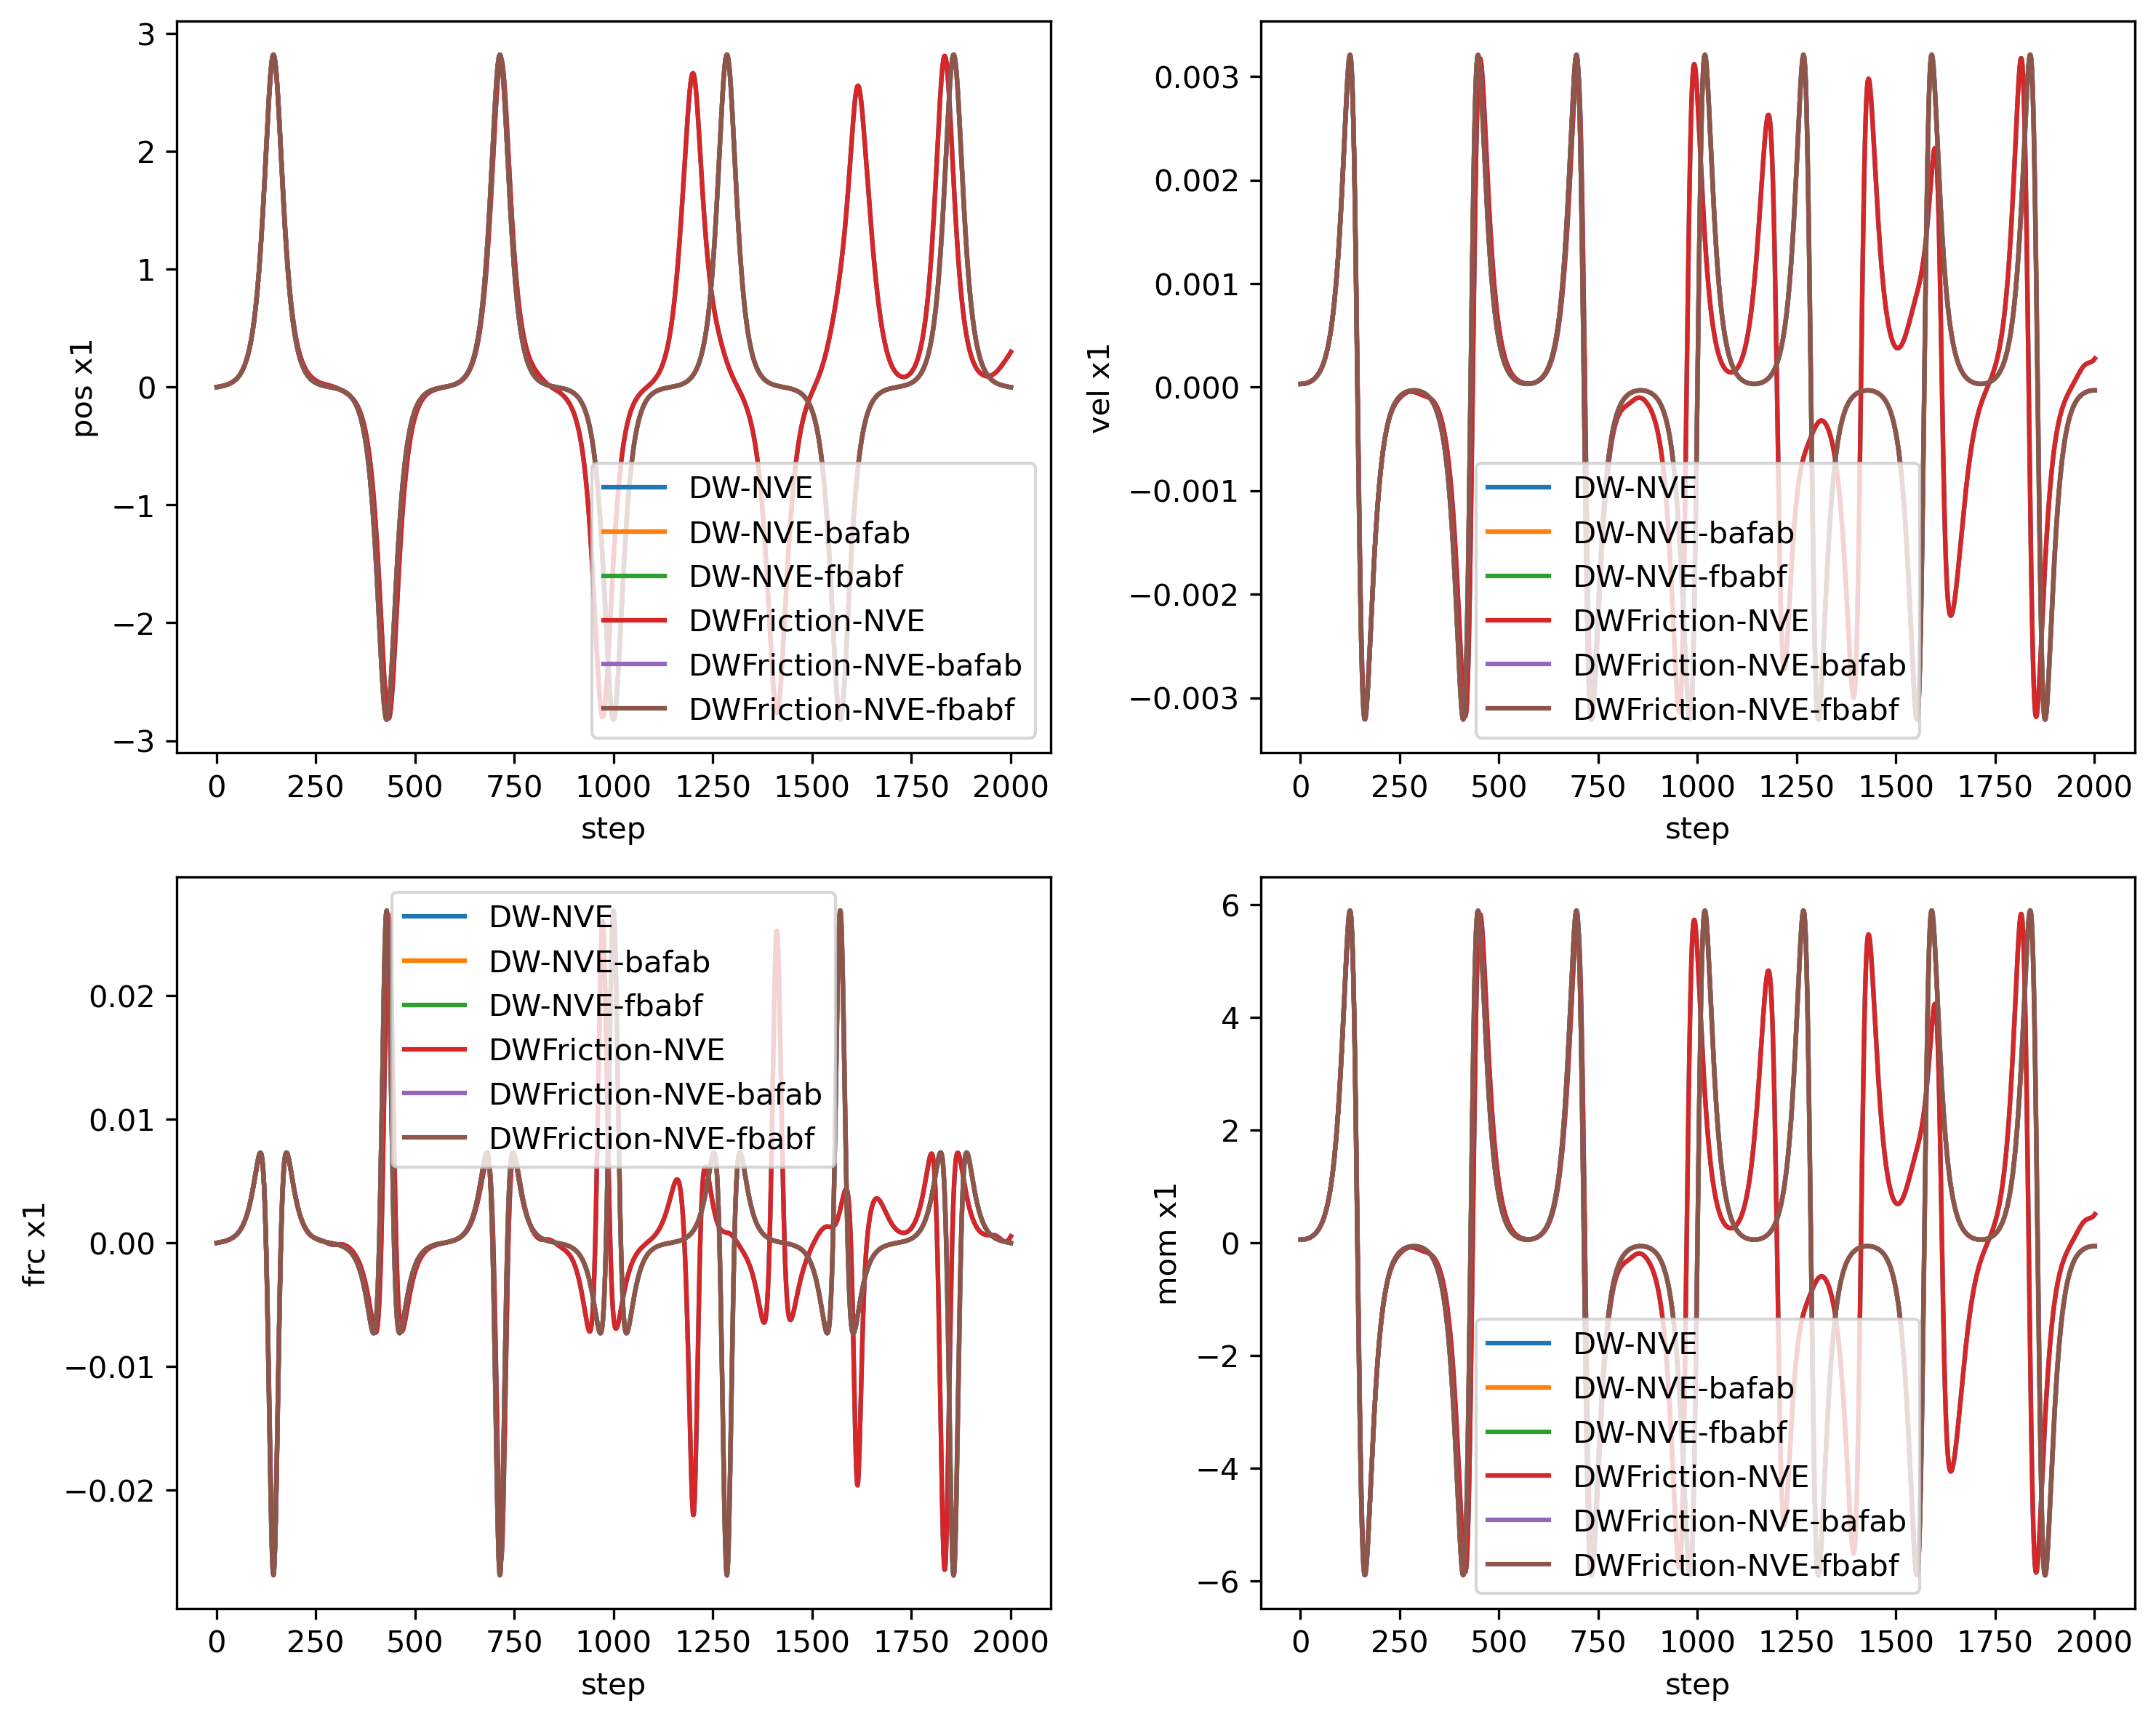

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, tight_layout=True)

for ax, prop in zip((axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]), PROPERTIES):
    quantity = f"x1"
    for simulation, df in traj.items():
        if simulation.startswith("DWBath") or "NVT" in simulation:
            continue
        ax.plot(
            df[f"{prop}_step"],
            df[f"{prop}_{quantity}"],
            label=simulation,
        )
    ax.set_xlabel("step")
    ax.set_ylabel(f"{prop} {quantity}")
    ax.legend()
plt.show()
# save in figures directory
fig.savefig(f"figures/NVE-all-props-x1.png")

## Compairing NVE-f (in i-PI) and NVE from George code as reference

First of all thank you George for providing the script as reference calculator.
From the reference calculator script the positions and momenta are printed for the particles and the bath.

The comparison is mostly qualitatively, because of different initial starting conditions, in i-PI example start from momenta=0 while for script momenta are initialized from a distribution. Main point of comparison is therefore the shape and dynamics as the particle moves through the double well potential.

In [16]:
def read_reference_csv(filename: str, name: str) -> pl.DataFrame:
    """Read reference positions from a CSV file into a Polars DataFrame."""
    data = {
        "time": [],
        f"{name}_average": [],
        f"{name}_values": [],
    }
    with open(filename, "r") as fd:
        for line in fd.readlines():
            values = [value for value in line.split(" ") if value]
            time = values[0]
            average = sum(float(v) for v in values[1:]) / (len(values) - 1)
            data["time"].append(float(time))
            data[f"{name}_average"].append(average)
            data[f"{name}_values"].append([float(v) for v in values[1:]])
    return pl.DataFrame(data)

reference = {
    prop: read_reference_csv(f"reference-gle-rpmd/{prop}.csv", prop)
    for prop in ("positions", "momenta")
}

In [17]:
reference["positions"].head()

shape: (5, 3)
┌───────────┬───────────────────┬─────────────────────────────────┐
│ time      ┆ positions_average ┆ positions_values                │
│ ---       ┆ ---               ┆ ---                             │
│ f64       ┆ f64               ┆ list[f64]                       │
╞═══════════╪═══════════════════╪═════════════════════════════════╡
│ 0.0       ┆ 0.0               ┆ [0.0, 0.0, … 0.0]               │
│ 41.341373 ┆ 0.001287          ┆ [-0.025808, 0.000623, … 0.0040… │
│ 82.682747 ┆ 0.002584          ┆ [-0.042164, -0.001203, … 0.006… │
│ 124.02412 ┆ 0.003905          ┆ [-0.043545, -0.006105, … 0.004… │
│ 165.36549 ┆ 0.005261          ┆ [-0.030503, -0.012098, … 0.000… │
└───────────┴───────────────────┴─────────────────────────────────┘

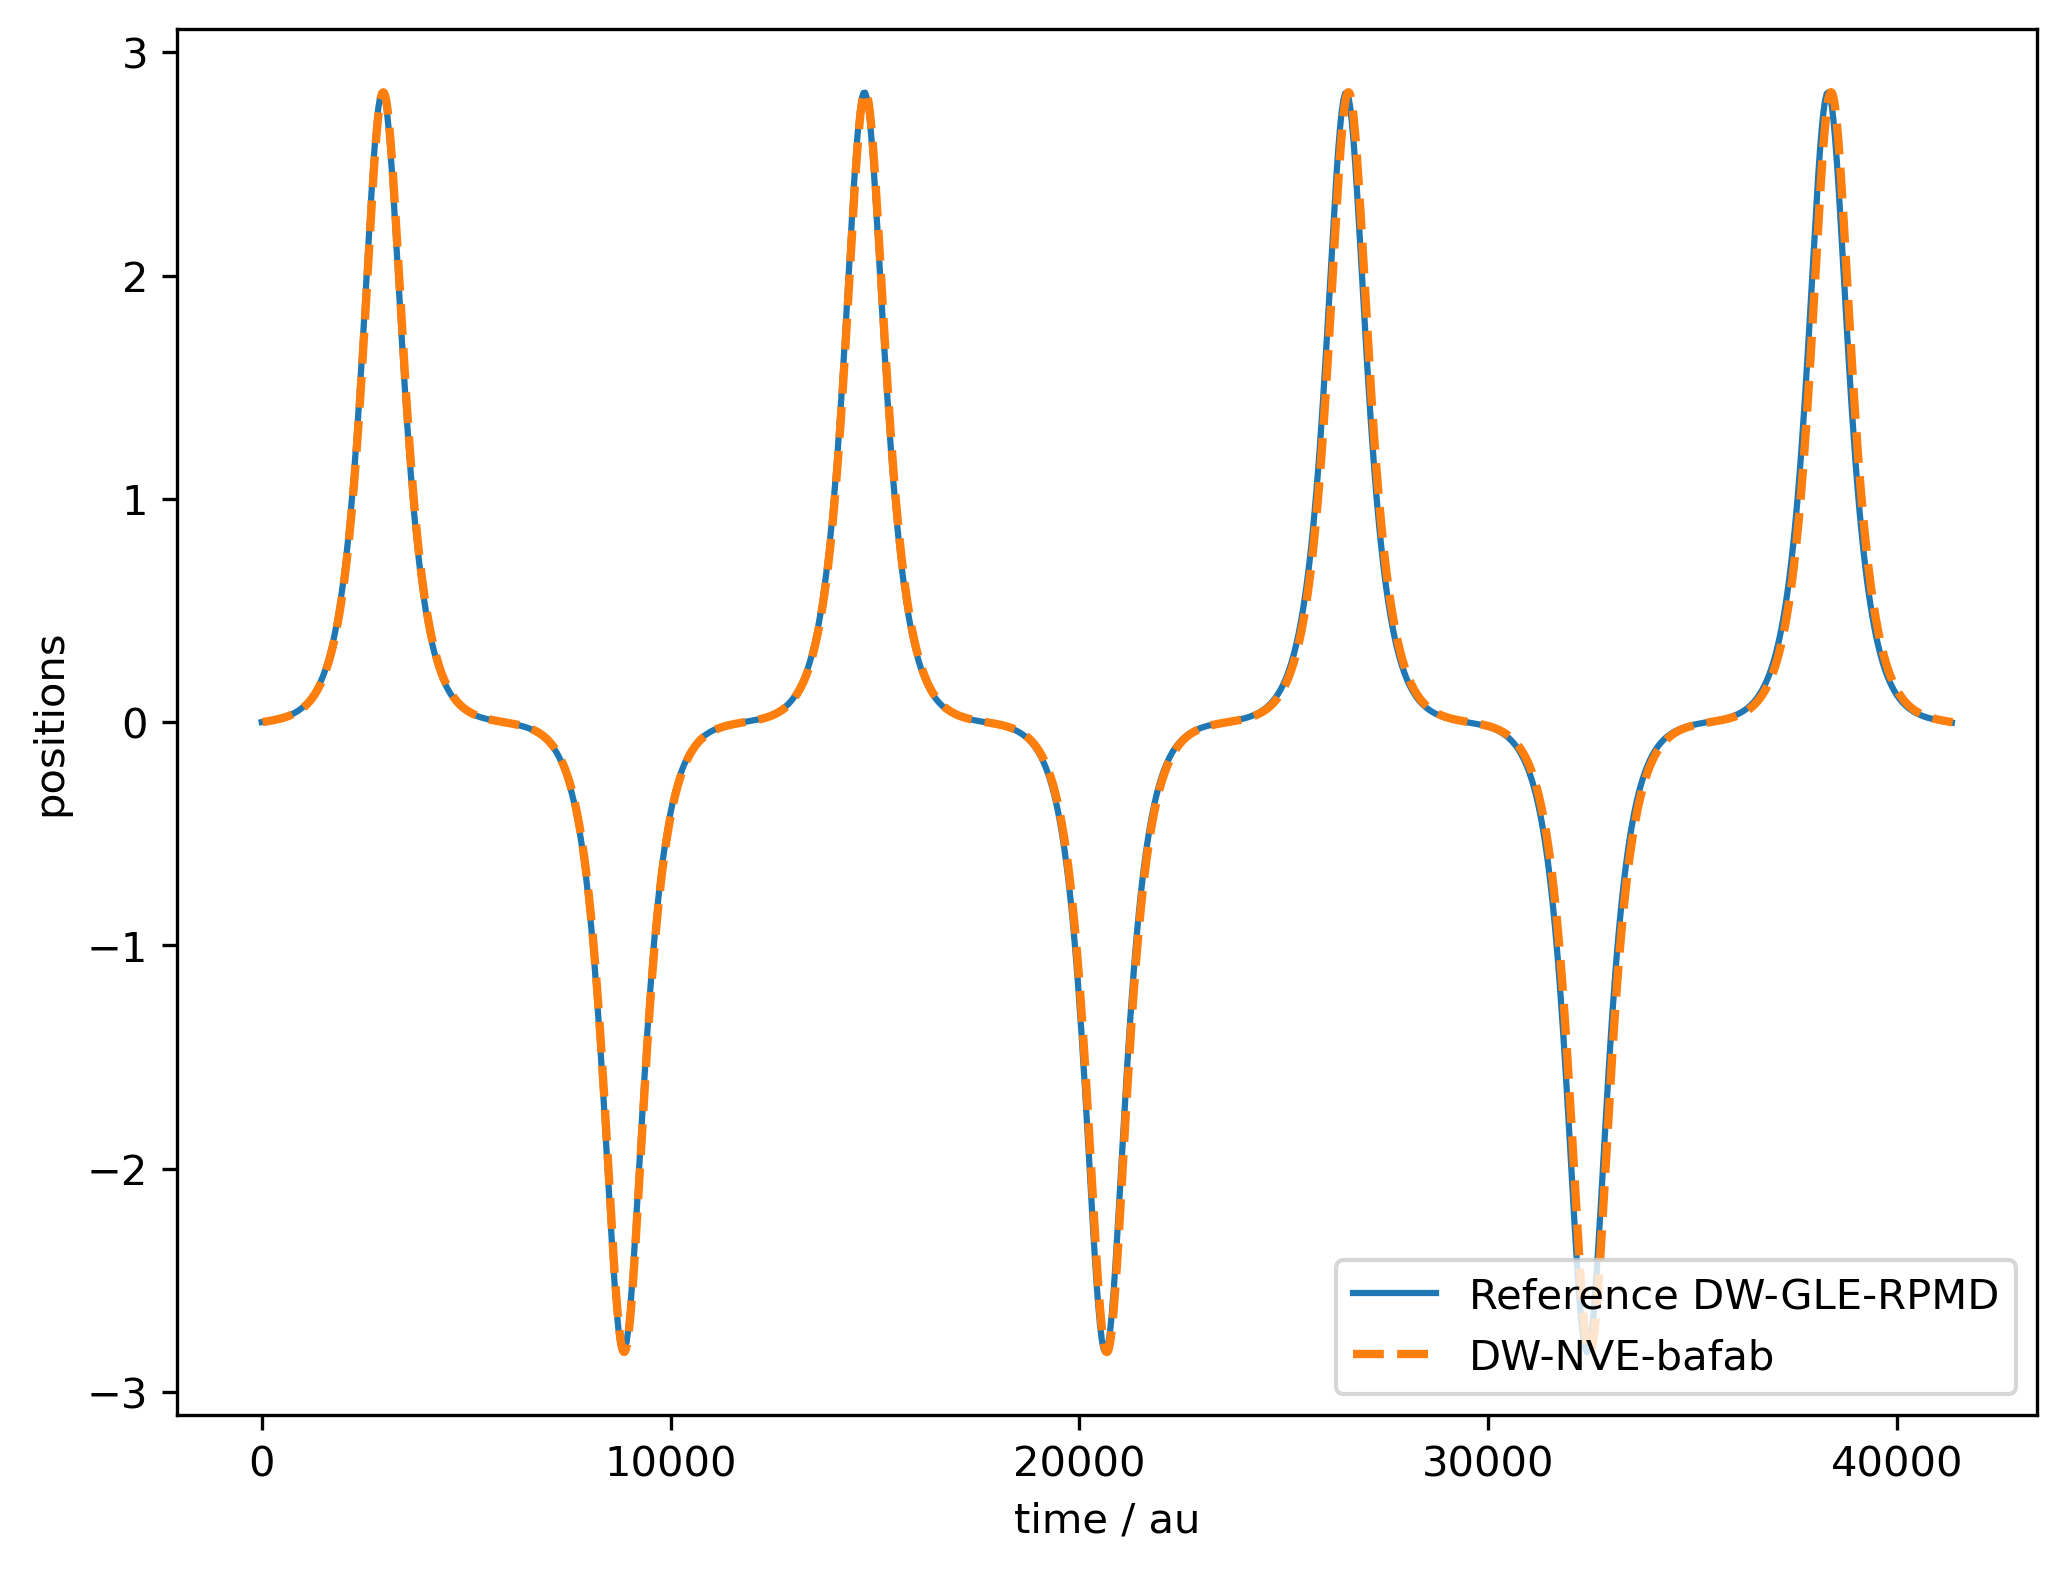

<Figure size 640x480 with 0 Axes>

In [ ]:
STEP_TO_AUTIME = 41.341374575751 *0.5
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(reference["positions"]["time"], reference["positions"]["positions_average"])
plt.plot(traj["DW-NVE-bafab"]["pos_step"] * STEP_TO_AUTIME, traj["DW-NVE-bafab"]["pos_x1"], linestyle="--", linewidth= 2)
plt.legend(["Reference DW-GLE-RPMD", "DW-NVE-bafab"])

plt.xlabel("time / au")
plt.ylabel("positions")
plt.show()
# save in figures directory
#plt.savefig("figures/reference_vs_DW-NVE-bafab-positions-x1.png")


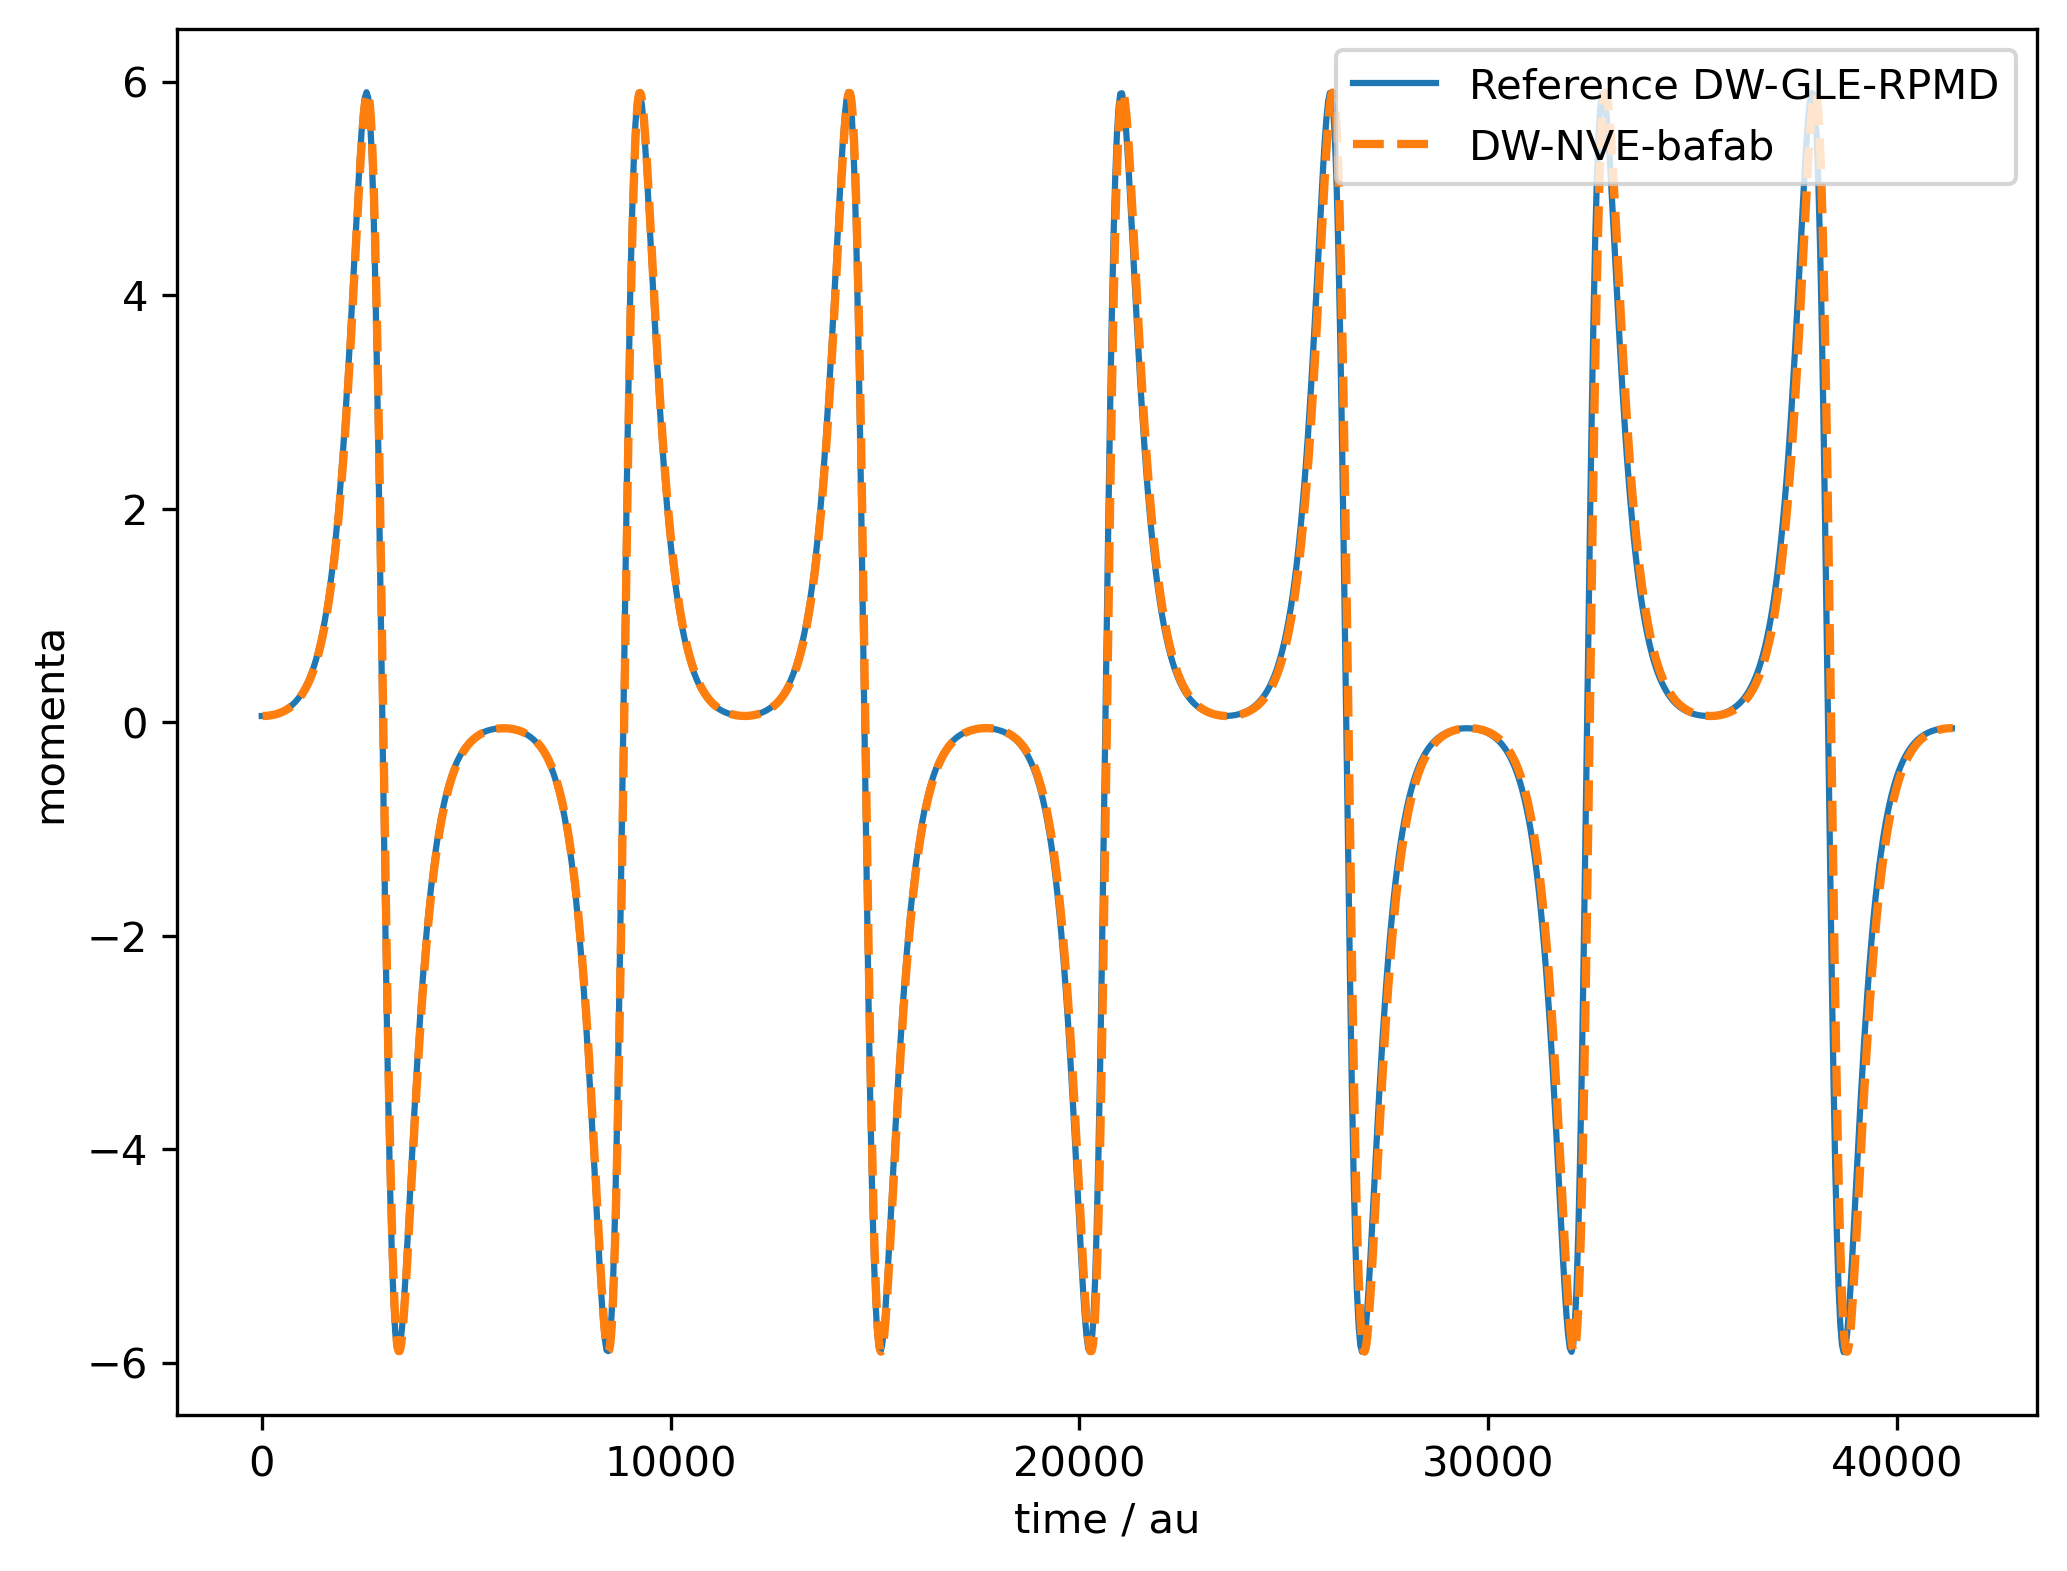

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(reference["momenta"]["time"], reference["momenta"]["momenta_average"])
plt.plot(traj["DW-NVE-bafab"]["mom_step"] * STEP_TO_AUTIME, traj["DW-NVE-bafab"]["mom_x1"], linestyle="--", linewidth= 2)
plt.legend(["Reference DW-GLE-RPMD", "DW-NVE-bafab"])

plt.xlabel("time / au")
plt.ylabel("momenta")
plt.show()
#plot position and momenta is one figure
#plt.savefig("figures/reference_vs_DW-NVE-bafab-momenta-x1.png")


In [20]:
initial_momenta = next(reference["momenta"].iter_rows())[1:]
initial_momenta

(0.057091906343749985,
 [-1.2233308,
  0.048892379,
  0.5651168,
  0.11641069,
  0.65882294,
  2.2219742,
  -1.1279764,
  0.72116202,
  -1.2708492,
  0.26219209,
  -0.3908678,
  1.0097007,
  -0.656181,
  0.39624481,
  -0.96499172,
  -1.646889,
  0.33159447,
  1.322071,
  0.39673371,
  -0.76440462,
  0.20468127,
  0.58516454,
  0.9086459,
  -0.88281816,
  0.53108895,
  0.26801884,
  -0.02472469,
  0.010054284,
  -0.51809971,
  -0.47331245,
  1.0153872,
  0.19742976])

In [21]:
# Write initial momenta to an XYZ file
with open("initial_momenta.xyz", "w") as f:
    for moment in initial_momenta:
        f.write(f"1\nCELL(abcABC): 300.0 300.0 300.0 90.0 90.0 90.0 cell{{atomic_unit}} Traj: momenta{{atomic_unit}}\nH {moment} 0.0 0.0\n")

In [22]:
initial_coordinate = next(reference["positions"].iter_rows())[1:]
initial_coordinate

(0.0,
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

In [23]:
# Write initial cordination to an XYZ file
with open("init.xyz", "w") as f:
    for positions in initial_coordinate:
        f.write(f"1\nCELL(abcABC): 300.0 300.0 300.0 90.0 90.0 90.0 cell{{atomic_unit}} Traj: positions{{atomic_unit}}\nH {positions} 0.0 0.0\n")